<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/OpenMined/PipelineDP/blob/main/examples/quickstart.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/OpenMined/PipelineDP/blob/main/examples/quickstart.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This is a simple example that shows how to calculate anonymized statistics using PipelineDP. The input data is a simulated dataset of visits to some restaurant during a 7 day period. Each visit is characterized by a visitor ID, the entry date, and the amount of money spent. In this colab we use Pipeline DP
Core API to calculate the count of restaurant visits per day.


# Install dependencies and download data

Run the code below to install the necessary dependencies, load and explore the input data.


In [1]:
#@markdown Install dependencies and download data

import os
os.chdir('/content')
!git clone https://github.com/OpenMined/PipelineDP.git
!pip install -r PipelineDP/requirements.dev.txt

import sys
sys.path.insert(0,'/content/PipelineDP')

#Download restaurant dataset from github
!wget https://raw.githubusercontent.com/google/differential-privacy/main/examples/go/data/week_data.csv

from IPython.display import clear_output
clear_output()

import apache_beam as beam
from apache_beam.runners.portability import fn_api_runner
from apache_beam.runners.interactive import interactive_runner
from apache_beam.runners.interactive.interactive_beam import *
import pyspark
from dataclasses import dataclass
import pipeline_dp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('week_data.csv')
df.rename(inplace=True, columns={'VisitorId' : 'user_id', 'Time entered' : 'enter_time', 'Time spent (minutes)' : 'spent_minutes', 'Money spent (euros)' : 'spent_money', 'Day' : 'day'})
rows = [index_row[1] for index_row in df.iterrows()]
df.head()

,user_id,enter_time,spent_minutes,spent_money,day
0,580,9:27AM,29,17,1
1,1215,9:16AM,45,18,1
2,448,11:55AM,12,16,1
3,125,10:47AM,27,20,1
4,484,11:08AM,35,13,1


# Run the pipeline

In [12]:
# Set the backend to local backend. Other options (Beam or Spark)
# are possible.
backend = pipeline_dp.LocalBackend()

# Define the total budget.
budget_accountant = pipeline_dp.NaiveBudgetAccountant(total_epsilon=1, total_delta=1e-6)

# Create DPEngine which will execute the logic.
dp_engine = pipeline_dp.DPEngine(budget_accountant, backend)

# Define privacy ID, partition key and aggregated value extractors.
# The aggregated value extractor isn't used in this example.
data_extractors = pipeline_dp.DataExtractors(
   partition_extractor=lambda row: row.day,
   privacy_id_extractor=lambda row: row.user_id,
   value_extractor=lambda row: 1)

# Configure the aggregation parameters.
params = pipeline_dp.AggregateParams(
   noise_kind=pipeline_dp.NoiseKind.LAPLACE,
   # This example computes only count but we can compute multiple
   # ... metrics at once.
   metrics=[pipeline_dp.Metrics.COUNT],
   # Limits visits contributed by a visitor. A visitor can contribute to
   # ... up to 3 days   
   max_partitions_contributed=3,
   # ... and up to 2 visits per day. 
   max_contributions_per_partition=2,
   # Configure the output partition keys as they are publicly known.
   # The output should include all week days.
   public_partitions=list(range(1, 8)))

# Create a computational graph for the aggregation.
# All computations are lazy. dp_result is iterable, but iterating it would
# fail until budget is computed (below).
# It’s possible to call DPEngine.aggregate multiple times with different
# metrics to compute.
dp_result = dp_engine.aggregate(rows, params, data_extractors)

# Compute budget per each DP operation. 
budget_accountant.compute_budgets()

# Here's where the lazy iterator initiates computations and gets transformed
# into actual results
dp_result = list(dp_result)


# Inspect the result

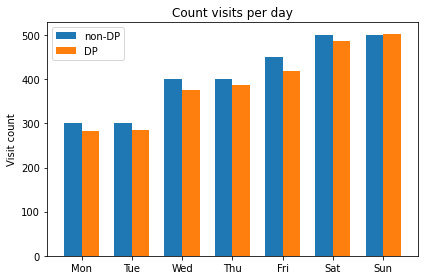

In [11]:
#@markdown ##Inspect the result
#@markdown Below you can see the DP and non-DP results.

# Compute non-DP result
non_dp_count = [0] * 7
days = range(1, 7)
for row in rows:
  index = row['day'] - 1
  non_dp_count[index] += 1

# Copy the DP result to a list
dp_count = [0] * 7 
for count_sum_per_day in dp_result:
  index =  count_sum_per_day[0] - 1
  dp_count[index] = count_sum_per_day[1][0]

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
x = np.arange(len(days))

width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, non_dp_count, width, label='non-DP')
rects2 = ax.bar(x + width/2, dp_count, width, label='DP')
ax.set_ylabel('Visit count')
ax.set_title('Count visits per day')
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.legend()
fig.tight_layout()
plt.show()

